2024-12-17 18:06:08.877948: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 18:06:08.935596: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 18:06:08.935665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 18:06:08.937163: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 18:06:08.948704: I tensorflow/core/platform/cpu_feature_guar

Epoch 1/200


2024-12-17 18:06:26.485870: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-12-17 18:06:26.612757: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-17 18:06:27.077867: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-17 18:06:33.691595: I external/local_xla/xla/service/service.cc:168] XLA service 0x7829ad454d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-17 18:06:33.691647: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-12-17 18:06:33.697873: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734438993.868491   28801 device_compiler.h:186] 

6/6 [==============================] - ETA: 0s - loss: 1.6578 - accuracy: 0.7376 - dice_coefficient: 0.0655 - jaccard_index: 0.0345 

/home/icmr/myenv_py311/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 145s 24s/step - loss: 1.6578 - accuracy: 0.7376 - dice_coefficient: 0.0655 - jaccard_index: 0.0345 - val_loss: 0.0634 - val_accuracy: 0.8443 - val_dice_coefficient: 0.1614 - val_jaccard_index: 0.0879
Epoch 2/200
6/6 [==============================] - 88s 17s/step - loss: 0.0756 - accuracy: 0.8340 - dice_coefficient: 0.1568 - jaccard_index: 0.0854 - val_loss: 0.0472 - val_accuracy: 0.8185 - val_dice_coefficient: 0.1660 - val_jaccard_index: 0.0905
Epoch 3/200
6/6 [==============================] - 99s 20s/step - loss: 0.0626 - accuracy: 0.8340 - dice_coefficient: 0.1881 - jaccard_index: 0.1043 - val_loss: 0.0433 - val_accuracy: 0.8443 - val_dice_coefficient: 0.2354 - val_jaccard_index: 0.1334
Epoch 4/200
6/6 [==============================] - 110s 22s/step - loss: 0.0555 - accuracy: 0.8340 - dice_coefficient: 0.2314 - jaccard_index: 0.1319 - val_loss: 0.0533 - val_accuracy: 0.8694 - val_dice_coefficient: 0.2296 - val_jaccard_index: 0.1297
Epoch 5/20

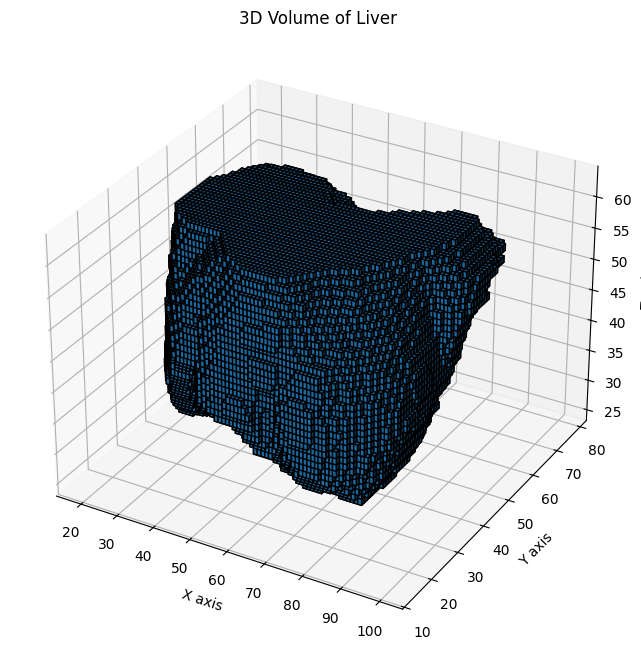

Processing file 2/4: liver_1P.nii.gz
1/1 [==============================] - 0s 24ms/step
Calculated volume for liver_1P.nii.gz: 551736.86 cubic units


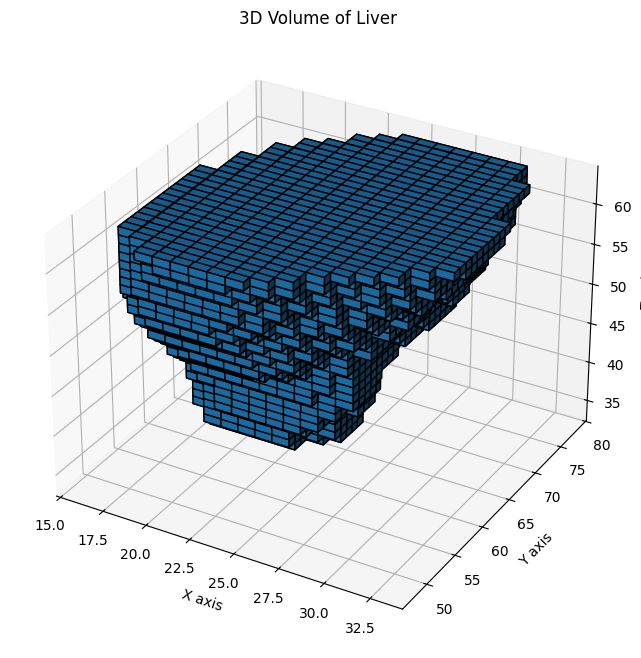

Processing file 3/4: liver_10P.nii.gz
1/1 [==============================] - 0s 24ms/step
Calculated volume for liver_10P.nii.gz: 758506.52 cubic units


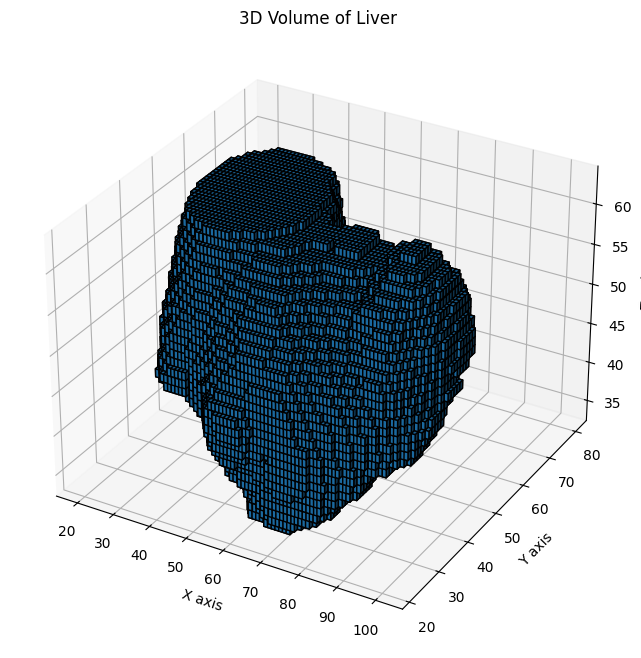

Processing file 4/4: liver_16P.nii.gz
1/1 [==============================] - 0s 25ms/step
Calculated volume for liver_16P.nii.gz: 782089.59 cubic units


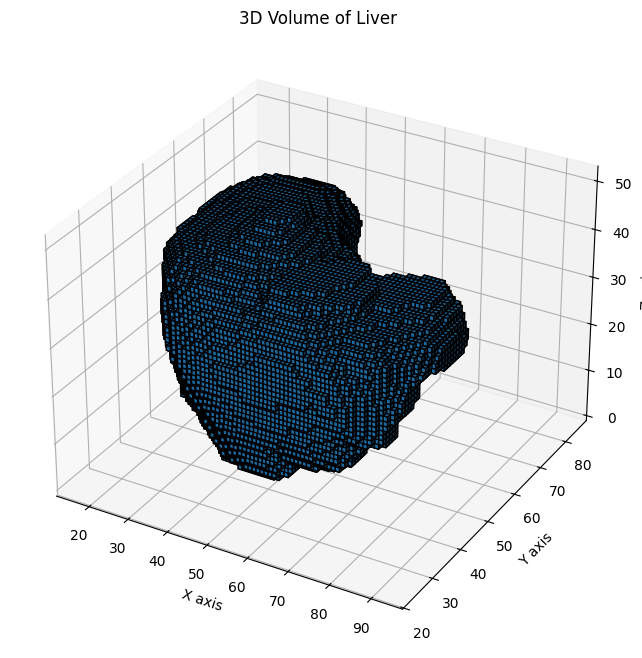

In [1]:
import os
import numpy as np
import numpy as np
import cv2
import nibabel as nib
#%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from skimage.transform import resize
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import scipy.ndimage

# Function to load NIfTI files with memory mapping
def load_nifti_memmap(file_path):
    img = nib.load(file_path)
    data = img.get_fdata(dtype=np.float32, caching='unchanged')  # Memory-mapped array
    affine = img.affine
    header = img.header
    return data, affine, header

# Generator function to load data in batches
def data_generator(file_list, data_path, mask_path, batch_size, target_shape=None):
    while True:
        np.random.shuffle(file_list)
        for start in range(0, len(file_list), batch_size):
            end = min(start + batch_size, len(file_list))
            batch_files = file_list[start:end]
            
            X_batch = []
            y_batch = []
            
            for filename in batch_files:
                img_path = os.path.join(data_path, filename)
                corresponding_mask_path = os.path.join(mask_path, filename)
                
                image, _, _ = load_nifti_memmap(img_path)
                mask, _, _ = load_nifti_memmap(corresponding_mask_path)
                
                # Ensure image and mask have the same shape (and possibly resize if needed)
                if target_shape:
                    image = resize_volume(image, target_shape)
                    mask = resize_volume(mask, target_shape)
                
                X_batch.append(image)
                y_batch.append(mask)
            
            X_batch = np.array(X_batch)[..., np.newaxis]  # Adding channel dimension
            y_batch = np.array(y_batch)[..., np.newaxis]  # Adding channel dimension
            
            yield X_batch, y_batch

# Function to resize volumes (if needed)
def resize_volume(img, target_shape):
    current_shape = img.shape
    if current_shape == target_shape:
        return img
    # Example: using scipy for interpolation
    resized_img = scipy.ndimage.zoom(img, (target_shape[0]/current_shape[0], target_shape[1]/current_shape[1], target_shape[2]/current_shape[2]), order=3)
    return resized_img

def resize_image(image, target_shape):
    # Resize the image to match the target shape (height, width)
    return resize(image, target_shape, preserve_range=True, anti_aliasing=True)

def pad_or_crop_volume(volume, target_shape):
    current_shape = volume.shape
    
    # Calculate padding width for each dimension
    pad_width = [(0, max(target_shape[i] - current_shape[i], 0)) for i in range(3)]
    
    # Pad the volume to the target shape
    volume = np.pad(volume, pad_width, mode='constant', constant_values=0)
    
    # Calculate cropping dimensions for each dimension
    crop_start = [(volume.shape[i] - target_shape[i]) // 2 for i in range(3)]
    crop_end = [crop_start[i] + target_shape[i] for i in range(3)]
    
    # Crop the volume to the target shape
    slices = [slice(crop_start[i], crop_end[i]) for i in range(3)]
    volume = volume[slices[0], slices[1], slices[2]]
    
    return volume

def calculate_volume(mask, voxel_volume):
    # Calculate the volume based on the mask
    return np.sum(mask) * voxel_volume
    
def unet_3d(input_shape):
    inputs = Input(input_shape)
    
    # Downsampling
    c1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(c1)
    c1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(c1)  # Added layer
    c1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(c1)  # Added layer
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(p1)
    c2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(c2)
    c2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(c2)  # Added layer
    c2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(c2)  # Added layer
    p2 = MaxPooling3D((2, 2, 2))(c2)
    
    c3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(p2)
    c3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(c3)
    c3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(c3)  # Added layer
    c3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(c3)  # Added layer
    
    # Upsampling
    u4 = UpSampling3D((2, 2, 2))(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(u4)
    c4 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(c4)
    c4 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(c4)  # Added layer
    c4 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(c4)  # Added layer
    
    u5 = UpSampling3D((2, 2, 2))(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(u5)
    c5 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(c5)
    c5 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(c5)  # Added layer
    c5 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(c5)  # Added layer
    
    outputs = Conv3D(1, (1, 1, 1), activation='sigmoid')(c5)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model
    
    model = Model(inputs, outputs)
    #model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', dice_coefficient, jaccard_index])
    return model

# Dice coefficient
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

# Jaccard index
def jaccard_index(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + 1)

# Example paths (update these to your dataset paths)
data_path = r'/home/icmr/Downloads/niigz dicom/Portal Phase'  # Update with the correct path
mask_path = r'/home/icmr/Downloads/niigz liver/Portal Phase'  # Update with the correct path

# Verify paths exist
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Data path not found: {data_path}")
if not os.path.exists(mask_path):
    raise FileNotFoundError(f"Mask path not found: {mask_path}")

# List of files
file_list = [filename for filename in os.listdir(data_path) if filename.endswith('.nii.gz')]

# Split the dataset
train_val_files, test_files = train_test_split(file_list, test_size=0.2, random_state=42)
train_files, val_files = train_test_split(train_val_files, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Define and compile the model
input_shape = (128, 128, 64, 1)  # Example input shape, adjust accordingly
model = unet_3d(input_shape)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', dice_coefficient, jaccard_index])
  
# Define callbacks
checkpoint = ModelCheckpoint('unet3d_best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define batch size
batch_size = 2

# Create data generators
train_generator = data_generator(train_files, data_path, mask_path, batch_size, target_shape=input_shape[:3])
val_generator = data_generator(val_files, data_path, mask_path, batch_size, target_shape=input_shape[:3])
test_generator = data_generator(test_files, data_path, mask_path, batch_size, target_shape=input_shape[:3])

# Calculate steps per epoch
steps_per_epoch = len(train_files) // batch_size
validation_steps = len(val_files) // batch_size
test_steps = len(test_files) // batch_size

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=200, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, callbacks=[checkpoint])

# Save the model
model.save('unet3d_model.h5')

# Evaluate the model on the test set
test_loss, test_accuracy, test_dice, test_jaccard = model.evaluate(test_generator, steps=test_steps)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Dice Coefficient: {test_dice}")
print(f"Test Jaccard Index: {test_jaccard}")


def display_results(model, file_list, data_path, mask_path, num_images=5):
    target_shape = (128, 128, 64)  # Fixed shape for all volumes
    num_images = min(num_images, len(file_list))  # Ensure we do not exceed the number of files
    
    for i in range(num_images):
        # Load image and mask
        image_file_path = os.path.join(data_path, file_list[i])
        mask_file_path = os.path.join(mask_path, file_list[i])
        
        print(f"Processing file {i+1}/{num_images}: {file_list[i]}")
        
        try:
            image = nib.load(image_file_path).get_fdata(dtype=np.float32)
            mask = nib.load(mask_file_path).get_fdata(dtype=np.float32)
            
            # Resize image and mask to expected shape
            image = resize_image(image, target_shape[:2])
            mask = resize_image(mask, target_shape[:2])
            
            # Pad or crop image and mask to match target depth
            image = pad_or_crop_volume(image, target_shape)
            mask = pad_or_crop_volume(mask, target_shape)
            
            # Preprocess image and mask
            image = image[..., np.newaxis]
            mask = mask[..., np.newaxis]

            # Get prediction
            prediction = model.predict(np.expand_dims(image, axis=0))[0, ..., 0]
            
            # Calculate the volume
            voxel_volume = np.prod(image.shape) / np.sum(mask > 0)  # Example volume calculation
            liver_volume = calculate_volume(mask, voxel_volume)
            print(f"Calculated volume for {file_list[i]}: {liver_volume:.2f} cubic units")

            # 3D Visualization
            fig = plt.figure(figsize=(8, 8))  # Reduced plot size
            ax = fig.add_subplot(111, projection='3d')
            ax.voxels(mask[..., 0] > 0, edgecolor='k')  # Display the mask in 3D
            
            ax.set_title("3D Volume of Liver")
            ax.set_xlabel("X axis")
            ax.set_ylabel("Y axis")
            ax.set_zlabel("Z axis")
            plt.show()
        
        except Exception as e:
            print(f"Error processing file {file_list[i]}: {e}")

# Assuming model, val_files, data_path, and mask_path are defined
display_results(model, val_files, data_path, mask_path)